# JPEG Compression

- Valérian FAYT <valerian.fayt>
- Romain HERMARY <romain.hermary>
- Quentin LE HELLOCO <quentin.le-helloco>

## Project

#### In this notebook, you have to:
* Illustrate and comment every different step of your algorithm, like if you had to explain it to someone who never heard of JPEG.
* Implement and analyses all relevant tests to demonstrate the proper functioning of the algorithm.

#### Your JPEG code should at least:
* Manage color, leaving the choice to the user to compress in RGB or YUV, as well as the sub-sampling options (4:4:4, 4:2:2 and 4:2:0) of chrominance.
* Manage images whose dimensions are not 8 multiples
* Let the user choose the quality indicator q for the luminance quantification matrix.
* Return for each macro-block, a compression indicator. This indicator may be define as in the course (number of coefficient by macro-block to code without compression (64) divide by the number of coefficient not null after zigzag linearisation of the DCT quantified matrix). It can be any other relevant indicator as well, if the choice is justified.

#### Bonus:
* Implement the conversion of DCT coefficients after quantification by Huffman table.

### JPEG Algorithm Summary

* Step 1 :
Split images in 8x8 blocks (if not multiple, add new columns/row with symmetrical inputs).

* Step 2 :
Apply DCT matrix (don't forget to -128)

* Step 3 :
Quantization of the matrix

* Step 4 :
Zigzag + Huffman compression

(Reversible to uncompress JPEG as well)

### Imports

In [1]:
# Numpy for the maths involving matrices
# Image for computation on images
import numpy as np
from PIL import Image

### Get list of pixels from image

'Original Image'

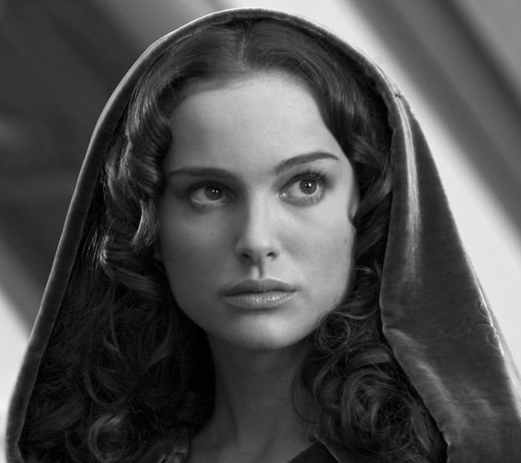

In [2]:
# A great picture... no We're not Star Wars fans! Why would you say that ?!
im = Image.open('Images/amidala_crop.png', 'r')
im = im.convert("L")
display("Original Image",im)

### Image Split

###### If the image's dimensions are not multiples of 8, make them by adding rows and columns, then divide the image into a list of 8x8 pixels macro-blocks.

In [3]:
def split(data):
    """
    Split a multiple of 8 image into 8x8 macro block list
    """
    
    blocks = []
    
    for i in range(0, data.shape[0], 8):
        for j in range(0, data.shape[1], 8):
            
            block = [[], [], [], [], [], [], [], []]
            
            for a in range (i, i + 8):
                for b in range (j, j + 8):
                    block[a - i].append(data[a][b])
                    
            blocks.append(block)
    return blocks

In [4]:
def multiple_8(matrix, debug=False):
    """
    Make any image's dimension into a multiple of 8 by adding rows and columns
    by border pixels mirroring (symmetry)
    """
    
    a, b = matrix.shape

    if a % 8 != 0 or b % 8 != 0 :
        if debug:
            print("Need padding...")
    else:
        return matrix

    padding_a = 8 - a % 8
    padding_b = 8 - b % 8

    # If the number of pixels to add on one line or a column is more
    # than the number of pixels available, it is problematic
    if padding_a > a or padding_b > b:
        print("Error: cannot do mirror padding, for now")
        return matrix
    
    matrix = matrix.tolist()
    
    # Mirror the pixels on the lines by copying and reversing the pixel line
    for i in range(a):
        tmp = matrix[i][b - padding_b:].copy()
        tmp.reverse()
        matrix[i] += tmp
    
    # Mirror the border lines starting from the bottom
    for i in range(padding_a):
        matrix.append(matrix[a - 1 - i])
    
    matrix = np.array(matrix)
    
    if debug:
        print('Dimension:', (a, b))
        print("Padding:", padding_a, padding_b)
        print('New Dimension:', matrix.shape)
        

    # The type of the matrix needs to be uint8
    return matrix.astype('uint8')

### Resizing the image to multiple of 8 and cut it into macro-block

Need padding...
Dimension: (463, 521)
Padding: 1 7
New Dimension: (464, 528)


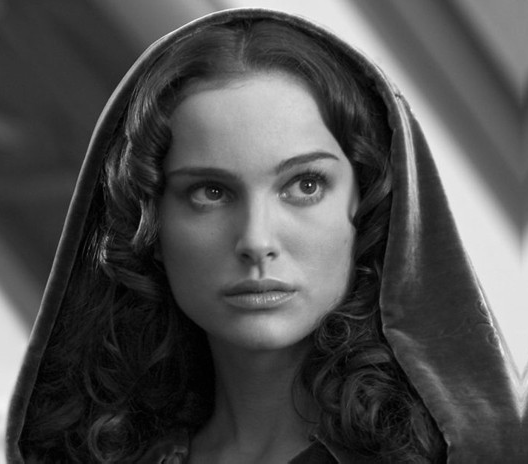

In [5]:
# Load the image into a numpy matrix and save dimensions
data = np.asarray(im)
original_dim = data.shape

# Make the matrix dimensions multiples of 8
data = multiple_8(data, debug=True)
img = Image.fromarray(data, 'L')
display(img)

# Cut into macro-block
macro_blocks = split(data)

 ###### For the purpose of this JPEG summary, we will take a look at one of the macro-block specifically.
 We randomly choose the 3104th.

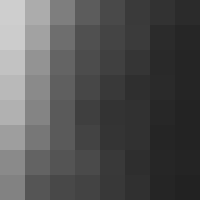

[[206 172 126  92  73  58  50  43]
 [204 162 110  80  68  59  43  38]
 [194 147 100  76  64  53  41  37]
 [185 138  95  71  57  47  42  37]
 [177 132  90  63  51  49  39  35]
 [158 119  90  67  52  49  37  35]
 [138  99  84  74  57  46  38  36]
 [130  85  72  67  56  48  37  34]]


In [6]:
# See a macro-block
block = macro_blocks[3104]
test_block = np.array(block)
test_macro = Image.fromarray(test_block, 'L')

# resize it to 200x200 because it's too small otherwise
test_macro = test_macro.resize((200,200), resample=0)
display(test_macro)
print(test_block)

### Apply DCT matrix

##### The DCT matrix represents different pattern images of 8x8 blocks depending on high-low frequency
##### We use this matrix as the new base for our image. In other words, we describe each macro block as a sum of each 8x8 pattern of the DCT matrix.

In [7]:
# Create DCT matrix for NxN dimensions
def DCT(N):
    
    mat = np.zeros(shape=(N,N))
    
    for i in range (N):
        mat[0,i] = np.sqrt(1/N)
        
    for i in range (1, N):
        for j in range (N):
            mat[i,j] = np.sqrt(2/N) * np.cos(np.pi * (2 * j + 1) * i / (2 * N))
    
    return mat

In [8]:
# Compute the 8x8 DCT matrix
D8 = DCT(8)

##### We apply the DCT to our macro-blocks matrices

In [9]:
macros = np.array(macro_blocks)

# Compute the DCT for each macro-block
Im_DCT = np.round(D8 @ (macros - 128) @ D8.T)

# Look a the same previous macro block (3104th)
print("3104th macro block applied to DCT:\n", Im_DCT[3104])

3104th macro block applied to DCT:
 [[1272. -207. -306. -194.  -71.   31.   79.   55.]
 [ -17.  -56.  -30.   37.   99.  138.  133.   84.]
 [  50.   37.    3.  -19.  -40.  -56.  -54.  -32.]
 [  30.   29.   11.  -11.  -24.  -24.  -20.  -13.]
 [ -32.  -38.  -14.    9.   31.   46.   40.   27.]
 [  15.   10.   -0.  -11.   -8.  -11.  -16.   -6.]
 [  17.   20.    9.   -5.  -18.  -24.  -22.  -14.]
 [ -21.  -25.  -12.    6.   22.   30.   28.   17.]]


### Quantization of the matrix

##### Using a predefine quantization matrix (thanks JPEG team), we can quantize the DCT matrix we obtained to reduce the values and increase the compression. 
##### We can specify a q factor to select a more advanced compression level (low q means low quality/high compression and reverse). Default is q = 50

In [10]:
# Create Matrix Quantification
def quantization(q=50):
    mat = np.zeros(shape=(8,8))
    
    Q_arr = [[16, 11, 10, 16, 24, 40, 51, 61],
         [12, 12, 14, 19, 26, 58, 60, 55],
         [14, 13, 16, 24, 40, 57, 69, 56],
         [14, 17, 22, 29, 51, 87, 80, 62],
         [18, 22, 37, 56, 68, 109, 103, 77],
         [24, 35, 55, 64, 81, 104, 113, 92],
         [49, 64, 78, 87, 103, 121, 120, 101],
         [72, 92, 95, 98, 112, 100, 103, 99]]
    
    Q = np.array(Q_arr)
    
    if q < 50:
        a = 5000/q
    else:
        a = 200 - 2 * q
        
    return np.floor((a * Q + 50 )/ 100)
        

##### Here is a look at the default q=50 quantization matrix

In [11]:
quantization()

array([[ 16.,  11.,  10.,  16.,  24.,  40.,  51.,  61.],
       [ 12.,  12.,  14.,  19.,  26.,  58.,  60.,  55.],
       [ 14.,  13.,  16.,  24.,  40.,  57.,  69.,  56.],
       [ 14.,  17.,  22.,  29.,  51.,  87.,  80.,  62.],
       [ 18.,  22.,  37.,  56.,  68., 109., 103.,  77.],
       [ 24.,  35.,  55.,  64.,  81., 104., 113.,  92.],
       [ 49.,  64.,  78.,  87., 103., 121., 120., 101.],
       [ 72.,  92.,  95.,  98., 112., 100., 103.,  99.]])

##### We divide (element-wise) our macro-blocks with the quantization matrix

In [12]:
# Element-Wise division
Im_q = np.round(Im_DCT / quantization())

# Always our little 3104th favorite macro-block
print("3104th macro block quantize to q = 50:\n", Im_q[3104])

3104th macro block quantize to q = 50:
 [[ 80. -19. -31. -12.  -3.   1.   2.   1.]
 [ -1.  -5.  -2.   2.   4.   2.   2.   2.]
 [  4.   3.   0.  -1.  -1.  -1.  -1.  -1.]
 [  2.   2.   0.  -0.  -0.  -0.  -0.  -0.]
 [ -2.  -2.  -0.   0.   0.   0.   0.   0.]
 [  1.   0.  -0.  -0.  -0.  -0.  -0.  -0.]
 [  0.   0.   0.  -0.  -0.  -0.  -0.  -0.]
 [ -0.  -0.  -0.   0.   0.   0.   0.   0.]]


### Zigzag

###### Seeing the face of the matrix, we can deduce that using a "zigzag" method of storing inputs will leads to a lot of 0 at the end that we can throw to reduce the overall data.

In [13]:
def zigzag(matrix):
    """
    Zigzag travel of a 8x8 matrix
    """
    x, y = 0, 0
    a, b = 7, 7
    direction = (0, 0)
    res = []
    
    while True:
        res.append(matrix[x][y])
        if y == b:
            res.append(matrix[x + 1][y])
            y -= 1
            x += 2
            direction = (1, -1)
        elif x == 0:
            res.append(matrix[x][y + 1])
            x +=1
            direction = (1, -1)
        elif x == a:
            res.append(matrix[x][y + 1])
            if y + 1 == b:
                break
            y += 2
            x -= 1
            direction = (-1, 1)
        elif y == 0:
            res.append(matrix[x + 1][y])
            y += 1
            direction = (-1, 1)
        else:
            x += direction[0]
            y += direction[1]

    return res

In [14]:
def zero_removal(l):
    """
    Remove unnecessary zeros at the end of the list
    """
    i = len(l) - 1
    while i >= 0 and l[i] == 0:
        i -= 1

    if i == -1:
        return [0.0]

    return l[:i + 1]

#### We can compute a Compression ratio by dividing the 64 coefficients in a 8x8 matrix with the remaining coefficient after doing the zigzag and removing the trailing 0

In [15]:
# Back to our image
# We compute a list of all macro-blocks zigzaged and removed from ending zeros
Im_zig = []

for i in range (len(Im_q)):
    Im_zig.append(zero_removal(zigzag(Im_q[i])))

# Hello to our little 3104th macro-block again!
print("Zigzag of macro-block 3104:",np.array(Im_zig[3104]), end="\n\n")
# Compression ratio for the 3104th macro-block:
print("compression ratio of macro block 3104: ",64 / len(Im_zig[3104]), end="\n\n\n")

# Maybe another?
print("Zigzag of macro-block 3105: ", Im_zig[3105], end="\n\n")
print("compression ratio of macro block 3105: ",64 / len(Im_zig[3105]), end="\n\n\n")

# Calculate the mean compression ratio:
means=0
for macros_b in Im_zig:
    means += 64 / len(macros_b)

means/=len(Im_zig)
print("Mean compression ratio for all macro-blocks: ", means)

Zigzag of macro-block 3104: [ 80. -19.  -1.   4.  -5. -31. -12.  -2.   3.   2.  -2.   2.   0.   2.
  -3.   1.   4.  -1.   0.  -2.   1.   0.   0.  -0.  -0.  -1.   2.   2.
   1.   2.  -1.  -0.   0.  -0.   0.  -0.  -0.   0.  -0.   0.  -0.  -1.
   2.  -1.]

compression ratio of macro block 3104:  1.4545454545454546


Zigzag of macro-block 3105:  [79.0, -0.0, -1.0, 0.0, 1.0, 1.0]

compression ratio of macro block 3105:  10.666666666666666


Mean compression ratio for all macro-blocks:  15.913490892492822


### Huffman

##### Huffman is used with optimised tables to compress data into shorter bytes. It is an encoding process to make lighter jpg files.

In [16]:
def category(n):
    """
    Derives the category of the given number, following the JPEG tables.
    Return the category and the boundaries of the latter for following calculus.
    """
    if n == 0:
        return 0, (0, 0)
    
    bound = 2
    res = 1
    while bound <= 32768:
        if -(bound - 1) <= n <= bound - 1:
            return res, (int(bound / 2), bound - 1)
        
        res += 1
        bound *= 2
        
    return -1, (-1, -1)

In [17]:
# These codes were used to extract te AC codes for luminance table
# The file 'category2' contains the values of the site given, but as the table
# was not complete, we found the rest of it elsewhere (the 'category' file)
# https://engineering.purdue.edu/~bouman/ece637/previous/ece637F1998/labs/lab8/pdf/lab.pdf
# As it is always the same, it is hard coded in the cell below
"""
ac_code = dict()
"""
# 'category' extraction
"""
with open("category", "r") as category:
    category = category.readlines()
    for line in category:
        line = line.split(' ')
        key = line[0].split('/')
        if line[2][-1] == '\n':
            line[2] = line[2][:-1]
        ac_code[(int(key[0], 16), int(key[1], 16))] = line[2]
"""

# 'category2' extraction
"""
with open("category2", "r") as category:
    category = category.readlines()
    i = 0
    while i < len(category):
        key = category[i][:-1].split(',')
        if category[i + 2][-1] == '\n':
            category[i + 2] = category[i + 2][:-1]
        ac_code[int(key[0]), int(key[1])] = category[i + 2]
        i += 4
"""
"""
print(ac_code)
"""

'\nprint(ac_code)\n'

In [18]:
# The tables stored as dictionnaries
dc_code = {
    0: "00",
    1: "010",
    2: "011",
    3: "100",
    4: "101",
    5: "110",
    6: "1110",
    7: "11110",
    8: "111110",
    9: "1111110",
    10: "11111110",
    11: "111111110"
}

ac_code = {(0, 1): '00', (0, 2): '01', (0, 3): '100', (0, 4): '1011', (0, 5): '11010', (0, 6): '1111000', (0, 7): '11111000', (0, 8): '1111110110', (0, 9): '1111111110000010', (0, 10): '1111111110000011', (1, 1): '1100', (1, 2): '11011', (1, 3): '1111001', (1, 4): '111110110', (1, 5): '11111110110', (1, 6): '1111111110000100', (1, 7): '1111111110000101', (1, 8): '1111111110000110', (1, 9): '1111111110000111', (1, 10): '1111111110001000', (2, 1): '11100', (2, 2): '11111001', (2, 3): '1111110111', (2, 4): '111111110100', (2, 5): '1111111110001001', (2, 6): '1111111110001010', (2, 7): '1111111110001011', (2, 8): '1111111110001100', (2, 9): '1111111110001101', (2, 10): '1111111110001110', (3, 1): '111010', (3, 2): '111110111', (3, 3): '111111110101', (3, 4): '1111111110001111', (3, 5): '1111111110010000', (3, 6): '1111111110010001', (3, 7): '1111111110010010', (3, 8): '1111111110010011', (3, 9): '1111111110010100', (3, 10): '1111111110010101', (4, 1): '111011', (4, 2): '1111111000', (4, 3): '1111111110010110', (4, 4): '1111111110010111', (4, 5): '1111111110011000', (4, 6): '1111111110011001', (4, 7): '1111111110011010', (4, 8): '1111111110011011', (4, 9): '1111111110011100', (4, 10): '1111111110011101', (5, 1): '1111010', (5, 2): '11111110111', (5, 3): '1111111110011110', (5, 4): '1111111110011111', (5, 5): '1111111110100000', (5, 6): '1111111110100001', (5, 7): '1111111110100010', (5, 8): '1111111110100011', (5, 9): '1111111110100100', (5, 10): '1111111110100101', (6, 1): '1111011', (6, 2): '111111110110', (6, 3): '1111111110100110', (6, 4): '1111111110100111', (6, 5): '1111111110101000', (6, 6): '1111111110101001', (6, 7): '1111111110101010', (6, 8): '1111111110101011', (6, 9): '1111111110101100', (6, 10): '1111111110101101', (7, 1): '11111010', (7, 2): '111111110111', (7, 3): '1111111110101110', (7, 4): '1111111110101111', (7, 5): '1111111110110000', (7, 6): '1111111110110001', (7, 7): '1111111110110010', (7, 8): '1111111110110011', (7, 9): '1111111110110100', (7, 10): '1111111110110101', (8, 1): '111111000', (8, 2): '111111111000000', (8, 3): '1111111110110110', (8, 4): '1111111110110111', (8, 5): '1111111110111000', (8, 6): '1111111110111001', (8, 7): '1111111110111010', (8, 8): '1111111110111011', (8, 9): '1111111110111100', (8, 10): '1111111110111101', (9, 1): '111111001', (9, 2): '1111111110111110', (9, 3): '1111111110111111', (9, 4): '1111111111000000', (9, 5): '1111111111000001', (9, 6): '1111111111000010', (9, 7): '1111111111000011', (9, 8): '1111111111000100', (9, 9): '1111111111000101', (9, 10): '1111111111000110', (10, 1): '111111010', (10, 2): '1111111111000111', (10, 3): '1111111111001000', (10, 4): '1111111111001001', (10, 5): '1111111111001010', (10, 6): '1111111111001011', (10, 7): '1111111111001100', (10, 8): '1111111111001101', (10, 9): '1111111111001110', (10, 10): '1111111111001111', (11, 1): '1111111001', (11, 2): '1111111111010000', (11, 3): '1111111111010001', (11, 4): '1111111111010010', (11, 5): '1111111111010011', (11, 6): '1111111111010100', (11, 7): '1111111111010101', (11, 8): '1111111111010110', (11, 9): '1111111111010111', (11, 10): '1111111111011000', (12, 1): '1111111010', (12, 2): '1111111111011001', (12, 3): '1111111111011010', (12, 4): '1111111111011011', (12, 5): '1111111111011100', (12, 6): '1111111111011101', (12, 7): '1111111111011110', (12, 8): '1111111111011111', (12, 9): '1111111111100000', (12, 10): '1111111111100001', (13, 1): '11111111000', (13, 2): '1111111111100010', (13, 3): '1111111111100011', (13, 4): '1111111111100100', (13, 5): '1111111111100101', (13, 6): '1111111111100110', (13, 7): '1111111111100111', (13, 8): '1111111111101000', (13, 9): '1111111111101001', (13, 10): '1111111111101010', (14, 1): '1111111111101011', (14, 2): '1111111111101100', (14, 3): '1111111111101101', (14, 4): '1111111111101110', (14, 5): '1111111111101111', (14, 6): '1111111111110000', (14, 7): '1111111111110001', (14, 8): '1111111111110010', (14, 9): '1111111111110011', (14, 10): '1111111111110100', (15, 0): '11111111001', (15, 1): '1111111111110101', (15, 2): '1111111111110110', (15, 3): '1111111111110111', (15, 4): '1111111111111000', (15, 5): '1111111111111001', (15, 6): '1111111111111010', (15, 7): '1111111111111011', (15, 8): '1111111111111100', (15, 9): '1111111111111101', (15, 10): '1111111111111110'}

In [19]:
def find_suffix(n, category, intb, extb):
    """
    Derives the index of the given number 'n' in its predetermined
    category, giving the suffix of its encoding
    """
    # Create 0 padding for the binary answer
    form = '{0:0' + str(category) + 'b}'
    # Search in the negative part of the category
    if n < 0:
        index = 0
        for i in range(-extb, -intb + 1):
            if i == n:
                return form.format(index)

            index += 1

    # Search in the positive part of the category
    index = extb - intb + 1
    for i in range(intb, extb + 1):
        if i == n:
            return form.format(index)
        
        index += 1
        
    return "error"

In [20]:
### SUFFIX ENCODING TEST AREA ###
categ, (intb, extb) = category(3)
print(categ, intb, extb)
find_suffix(3, categ, intb, extb)

2 2 3


'11'

In [21]:
def encode(l, prev_dc):
    """
    Find the Huffman encoding of the given list.
    The first coefficient is special, and gets special encoding.
    """
    # Calculate the DC coefficient encoding, as seen in the course,
    # with the difference between the previous coefficient and the actual one.
    # When calculating the first encoding coefficient of a row, the prev_dc is the
    # last coefficient of the previous row; we did not have the time and it
    # was not speciefied in the course, but we think a good way would have been to take
    # the first coefficient of the previous line to stay close and have a low
    # difference.
    delta_dc = l[0] - prev_dc
    categ, (intb, extb) = category(delta_dc)
    suffix = find_suffix(delta_dc, categ, intb, extb)
    res = dc_code[categ] + suffix
    
    # Encode the AC coefficents
    zeros = 0
    for n in l[1:]:
        if n == 0:
            if zeros < 15:
                zeros += 1
            continue

        categ, (intb, extb) = category(n)
        suffix = find_suffix(n, categ, intb, extb)
        res += ac_code[(zeros, categ)] + suffix
        
        zeros = 0
    
    # Return the block encoding ending it by EOB
    return res + '1010'

In [22]:
### HUFFMAN ENCODING TEST AREA ###
# This is the same table as in the course, but could not get the same result,
# as the tables in the slides and on the site are different
l = [-26, -3, 0, -3, -2, -6, 2, -4, 1, -3, 1, 1, 5, 1, 2, -1, 1, -1, 2, 0, 0, 0, 0, 0, -1, -1]
encode(l, 0)

'110001010100110110001011000010110100011001010000100110010100101100000010000110111101000001010'

### Reverse JPEG

##### After the JPEG Compression, we still need to uncompress the JPEG image to take a look at the compressed image we did
##### Fortunately, the JPEG algorithm is completely reversible, which means:
* Decode the Huffman (not shown here)
* Reverse the zigzag and add deleted ending zeros
* Multiply (element-wise) with the same q factor quantization matrix
* Reverse the DCT matrix application
* Merge all macro-blocks into one image again
* Crop the added row and column to regain original dimensions

In [23]:
def reverse_zigzag(l):
    x, y = 0, 0
    a, b = 7, 7
    direction = (0, 0)
    matrix = np.zeros(shape=(8,8))
    
    i = 0
    
    while True and i < len(l):
        matrix[x,y] = l[i]
        i+=1
        
        if i >=len(l):
            break
        if y == b:
            matrix[x + 1,y] = l[i]
            i+=1
            y -= 1
            x += 2
            direction = (1, -1)
        elif x == 0:
            matrix[x,y + 1] = l[i]
            i+=1
            x +=1
            direction = (1, -1)
        elif x == a:
            matrix[x,y + 1] = l[i]
            i+=1
            if y + 1 == b:
                break
            y += 2
            x -= 1
            direction = (-1, 1)
        elif y == 0:
            matrix[x + 1,y] = l[i]
            i+=1
            y += 1
            direction = (-1, 1)
        else:
            x += direction[0]
            y += direction[1]
        
    return matrix

In [24]:
def reverse_split(data, x, y):
    """
    Split a multiple of 8 image into 8x8 macro block list
    """
    
    image = np.zeros(shape=(x,y))
    index = 0
    
    for i in range(0, x, 8):
        for j in range(0, y, 8):
            
            for a in range (i, i + 8):
                for b in range (j, j + 8):
                    image[a,b] = data[index][a- i, b - j]
            index+=1
                    
    return image

#### Here is the reverse JPEG for our image

Reversed zigzag matrix:
 [[ 80. -19. -31. -12.  -3.   1.   2.   1.]
 [ -1.  -5.  -2.   2.   4.   2.   2.   2.]
 [  4.   3.   0.  -1.  -1.  -1.  -1.  -1.]
 [  2.   2.   0.  -0.  -0.  -0.   0.   0.]
 [ -2.  -2.  -0.   0.   0.   0.   0.   0.]
 [  1.   0.  -0.  -0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [ -0.  -0.   0.   0.   0.   0.   0.   0.]]

Reversed quantization matrix:
 [[1280. -209. -310. -192.  -72.   40.  102.   61.]
 [ -12.  -60.  -28.   38.  104.  116.  120.  110.]
 [  56.   39.    0.  -24.  -40.  -57.  -69.  -56.]
 [  28.   34.    0.   -0.   -0.   -0.    0.    0.]
 [ -36.  -44.   -0.    0.    0.    0.    0.    0.]
 [  24.    0.   -0.   -0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [  -0.   -0.    0.    0.    0.    0.    0.    0.]]

Reversed DCT matrix:
 [[204. 176. 378. 347. 342. 317. 308. 305.]
 [208. 161. 377. 337. 333. 308. 297. 293.]
 [201. 137. 370. 324. 328. 310. 301. 298.]
 [177. 128. 353. 308. 317. 311. 303. 

'3104th recovered macro-block'

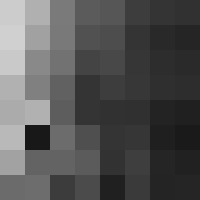

'Original 3104th macro-block'

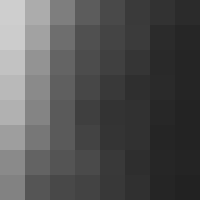

In [25]:
# Reverse zigzag
Im_rv_zig = []
for i in range(len(Im_zig)):
    Im_rv_zig.append(reverse_zigzag(Im_zig[i]))
                
print("Reversed zigzag matrix:\n",Im_rv_zig[3104], end="\n\n")

# Reverse Quantization
reverse_quant = Im_rv_zig * quantization()
print("Reversed quantization matrix:\n",reverse_quant[3104], end="\n\n")

# Reverse DCT
reverse_dct = np.round(D8.T @ reverse_quant @ D8)
reverse_dct += 128
print("Reversed DCT matrix:\n",reverse_dct[3104], end="\n\n")

# Show macro block
test_reverse = Image.fromarray(np.uint8(reverse_dct[3104]), 'L')

test_reverse = test_reverse.resize((200,200), resample=0)
display("3104th recovered macro-block", test_reverse)

display("Original 3104th macro-block", test_macro)

#### Here is the final recovered image from all recovered macro-blocks

[[ 61  59  57 ... 133 135 138]
 [ 60  58  57 ... 134 135 136]
 [ 62  61  59 ... 135 135 135]
 ...
 [222 225 219 ...  43  43  42]
 [221 224 219 ...  43  43  42]
 [221 224 219 ...  43  43  42]]

[[ 62  61  59 ... 135 136 136]
 [ 62  61  59 ... 135 136 136]
 [ 62  61  59 ... 135 136 136]
 ...
 [218 244 198 ...  43  43  43]
 [212 242 199 ...  42  42  42]
 [217 246 205 ...  42  42  42]]


'Original Image + added row and column'

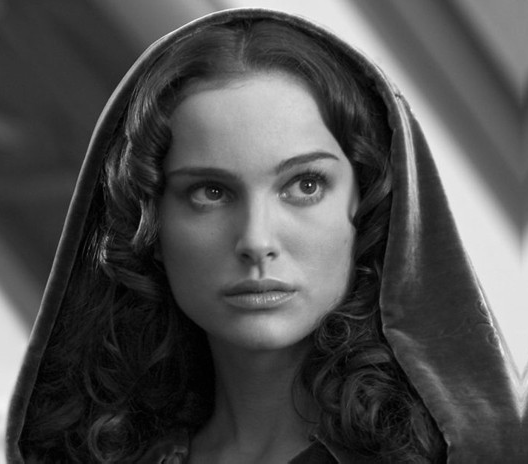

'Compressed Image at original dimensions'

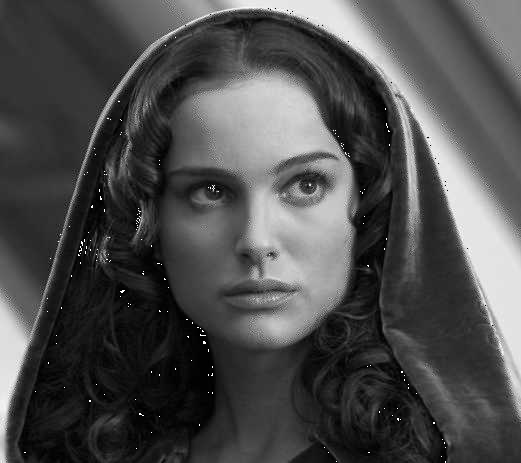

In [26]:
# Merge all macro_blocks into one image
recovered_im = reverse_split(reverse_dct ,data.shape[0], data.shape[1])
print(data, end="\n\n")
print(np.uint8(recovered_im))

# Crop the image to its original dimensions
reco_Im = Image.fromarray(np.uint8(recovered_im), 'L')
reco_Im = reco_Im.crop((0,0,original_dim[1], original_dim[0]))

# Show image
display("Original Image + added row and column", img)
display("Compressed Image at original dimensions", reco_Im)

### Here we try with the same macro-block as in the course, we can see we get the same result

Original macro-block: 
 [[ 52  55  61  66  70  61  64  73]
 [ 63  59  55  90 109  85  69  72]
 [ 62  59  68 113 144 104  66  73]
 [ 63  58  71 122 154 106  70  69]
 [ 67  61  68 104 126  88  68  70]
 [ 79  65  60  70  77  68  58  75]
 [ 85  71  64  59  55  61  65  83]
 [ 87  79  69  68  65  76  78  94]]

DCT macro-block: 
 [[-415.  -30.  -61.   27.   56.  -20.   -2.    0.]
 [   4.  -22.  -61.   10.   13.   -7.   -9.    5.]
 [ -47.    7.   77.  -25.  -29.   10.    5.   -6.]
 [ -49.   12.   34.  -15.  -10.    6.    2.    2.]
 [  12.   -7.  -13.   -4.   -2.    2.   -3.    3.]
 [  -8.    3.    2.   -6.   -2.    1.    4.    2.]
 [  -1.    0.    0.   -2.   -1.   -3.    4.   -1.]
 [  -0.    0.   -1.   -4.   -1.   -0.    1.    2.]]

Quantized macro-block: 
 [[-26.  -3.  -6.   2.   2.  -0.  -0.   0.]
 [  0.  -2.  -4.   1.   0.  -0.  -0.   0.]
 [ -3.   1.   5.  -1.  -1.   0.   0.  -0.]
 [ -4.   1.   2.  -1.  -0.   0.   0.   0.]
 [  1.  -0.  -0.  -0.  -0.   0.  -0.   0.]
 [ -0.   0.   0.  -0.  -0

'Recovered macro-block'

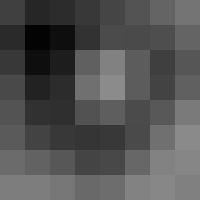

In [27]:
# Same example as in the course slide

course_mat = [[52, 55, 61, 66, 70, 61, 64, 73],
             [63, 59, 55, 90, 109, 85, 69, 72],
             [62, 59, 68, 113, 144, 104, 66, 73],
             [63, 58, 71, 122, 154, 106, 70, 69],
             [67, 61, 68, 104, 126, 88, 68, 70],
             [79, 65, 60, 70, 77, 68, 58, 75],
             [85, 71, 64, 59, 55, 61, 65, 83],
             [87, 79, 69, 68, 65, 76, 78, 94]]

mat_bi = np.array(course_mat)

print("Original macro-block: \n", mat_bi, end="\n\n")

# Apply DCT
bi = np.round(D8 @ (mat_bi - 128) @ D8.T)

print("DCT macro-block: \n", bi, end="\n\n")

# Quantization matrix
bi_q = np.round(bi / quantization())
print("Quantized macro-block: \n", bi_q, end="\n\n")

# Remove trailing 0
ms = zero_removal(zigzag(bi_q))
print("Zigzag list without trailing 0: \n", ms, end="\n\n")

# Reverse zigzag
zigzag_1 = reverse_zigzag(ms)
print("Reverse Zigzag matrix: \n", zigzag_1, end="\n\n")

# Reverse Quantization
reverse_quant = zigzag_1 * quantization(50)
print("Reversed Quantization matrix: \n",reverse_quant, end="\n\n")

# Reverse DCT
reverse_dct = np.round(D8 @ reverse_quant @ D8.T)
print("Reversed DCT matrix: \n",reverse_dct, end="\n\n")
reverse_dct += 128
print("Recovered Macro-block: \n", reverse_dct, end="\n\n")

# Show macro block
test_reverse = Image.fromarray(np.uint8(reverse_dct), 'L')

test_reverse = test_reverse.resize((200,200), resample=0)
display("Recovered macro-block",test_reverse)

## RGB - YUV 
#### Transform a one channel (R,G,B) or (Y,U,V) to three grayscale channels to pass into JPEG algorithm. This way, we can compress 3 time the image information using the grayscale JPEG algorithm

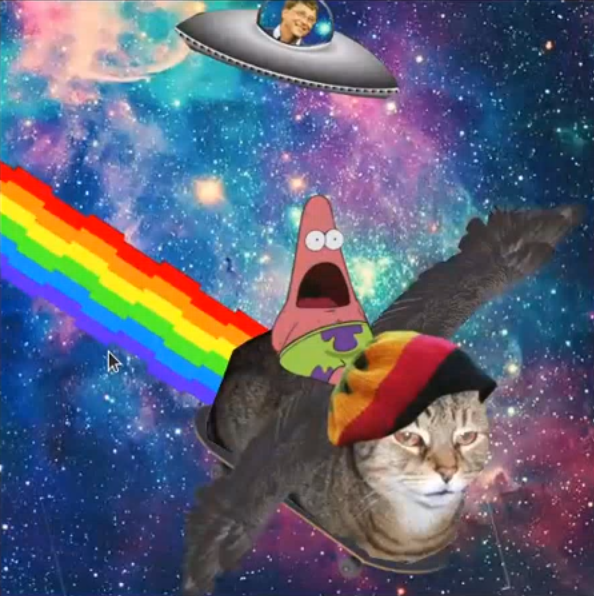

In [28]:
# A new Image that show best the different colors of RGB
im = Image.open('Images/rainbow_patrick.png', 'r')
im = im.convert("RGB")
display(im)

# Load the image into a numpy matrix
rgb_data = np.asarray(im)

In [29]:
def get_channel(data, c):
    
    mat = np.zeros(shape=(data.shape[0],data.shape[1]))
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            
            mat[i,j] = data[i, j][c]
    
    return mat

In [30]:
# Convert to YUV
def RGB2YUV(rgb):
     
    m = np.array([[ 0.29900, -0.16874,  0.50000],
                 [0.58700, -0.33126, -0.41869],
                 [ 0.11400, 0.50000, -0.08131]])
     
    yuv = np.dot(rgb,m)
    yuv[:,:,1:]+=128.0
    return yuv

# Convert to RGB
def YUV2RGB(yuv):
      
    m = np.array([[ 1.0, 1.0, 1.0],
                 [-0.000007154783816076815, -0.3441331386566162, 1.7720025777816772],
                 [ 1.4019975662231445, -0.7141380310058594 , 0.00001542569043522235] ])
    
    rgb = np.dot(yuv,m)
    rgb[:,:,0]-=179.45477266423404
    rgb[:,:,1]+=135.45870971679688
    rgb[:,:,2]-=226.8183044444304
    return rgb

#### Do you want RGB or YUV ?

In [31]:
rgb = False

### Here we separate the 3 channels R-G-B or Y-U-V into 3 grayscale images.

'channel 1'

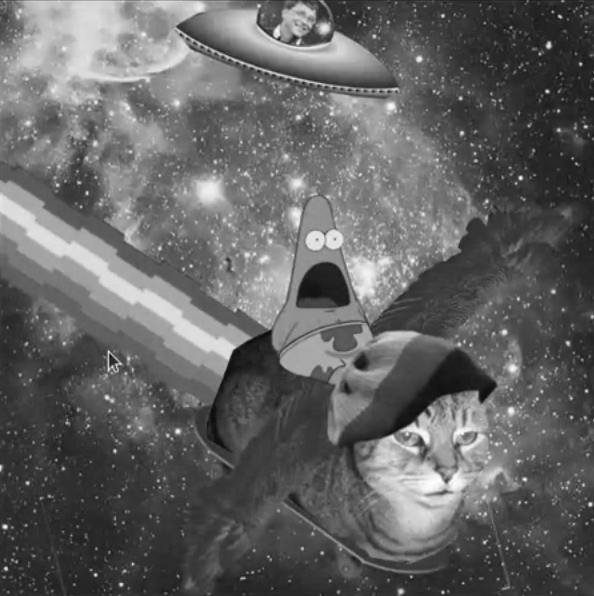

'channel 2'

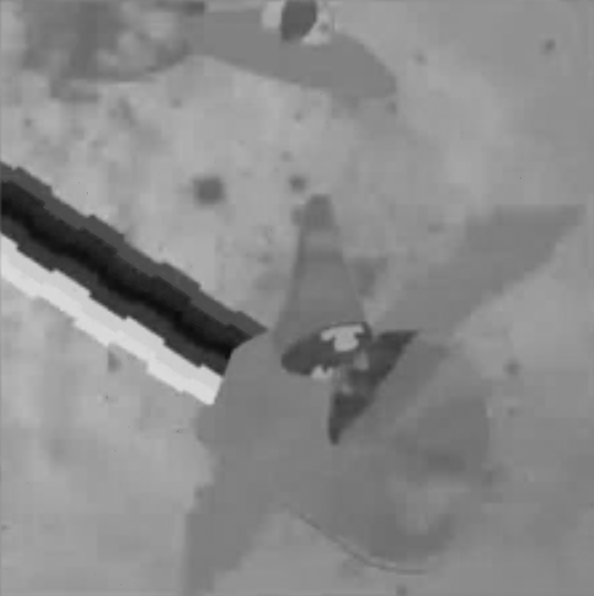

'channel 3'

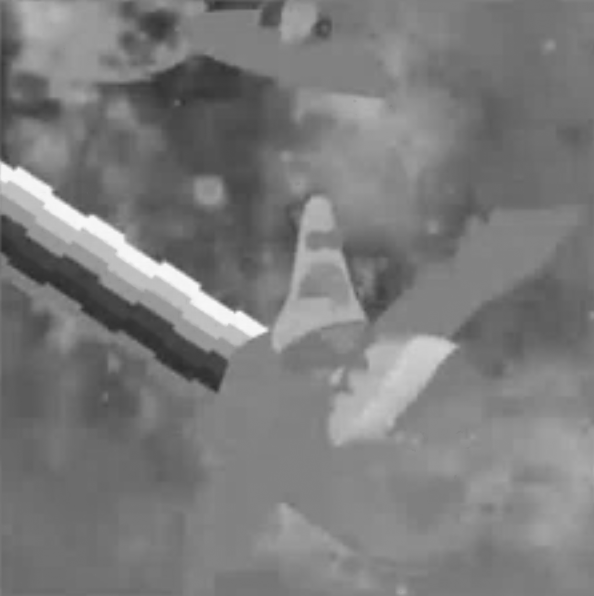

In [32]:
#Convert to YUV
if not rgb:
    rgb_data = RGB2YUV(rgb_data)

#print(data.shape)
red = get_channel(rgb_data, 0)
green = get_channel(rgb_data, 1)
blue = get_channel(rgb_data, 2)

#Show macro block
im_red = Image.fromarray(np.uint8(red), 'L')
im_green = Image.fromarray(np.uint8(green), 'L')
im_blue = Image.fromarray(np.uint8(blue), 'L')

display("channel 1", im_red)
display("channel 2",im_green)
display("channel 3",im_blue)

###### R-G-B and Y channels use the normal quantization matrix. The U and V channels use another quantization matrix which is:

In [33]:
# Matrix tu use for quantization with U and V channels
quant_UV = [[17,18,24,47,99,99,99,99],
                   [18,21,26,66,99,99,99,99],
                   [24,26,56,99,99,99,99,99],
                   [47,66,99,99,99,99,99,99],
                   [99,99,99,99,99,99,99,99],
                   [99,99,99,99,99,99,99,99],
                   [99,99,99,99,99,99,99,99],
                   [99,99,99,99,99,99,99,99]]

quantization_UV = np.array(quant_UV)

### Downsampling

###### Downsampling is used to gain even more compression by cropping the U and V channel in YUV compression. Because the two images are pretty "flat", removing one every two columns or row does not alter a lot the information.

There are 3 Dowsampling in YUV:
* 4:4:4 is normal compression
* 4:2:2 is one every two columns
* 4:2:0 is one every two columns and row

In [34]:
def downsampling_422(channel):
    new_col = int(channel.shape[1]/2)
    mat = np.zeros(shape=(channel.shape[0], new_col))
    
    for i in range(channel.shape[0]):
        for j in range(new_col):
            mat[i,j] = channel[i,j*2]
    
    return mat

In [35]:
def downsampling_420(channel):
    new_col = int(channel.shape[1]/2)
    new_row = int(channel.shape[0]/2)
    mat = np.zeros(shape=(new_row, new_col))
    
    for i in range(new_row):
        for j in range(new_col):
            mat[i,j] = channel[i*2,j*2]
    
    return mat

### Here you can see the 4:2:2 downsampling on U and V channels

'4:2:2 Channel U'

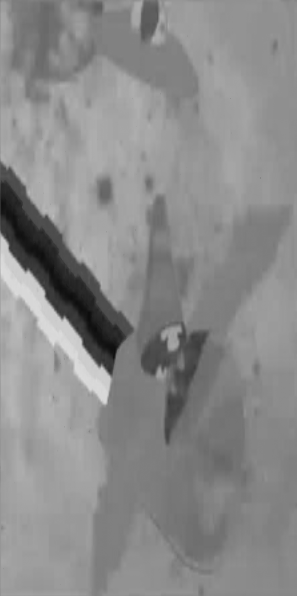

'4:2:2 Channel V'

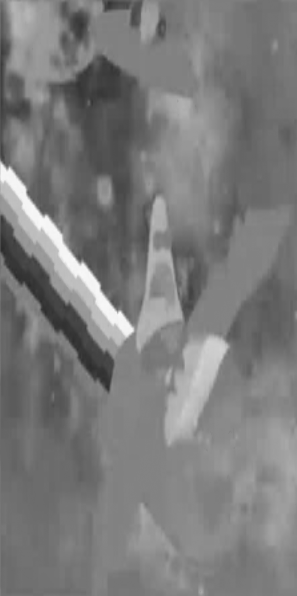

In [36]:
dw_422 = Image.fromarray(np.uint8(downsampling_422(green)), 'L')
display("4:2:2 Channel U", dw_422)

dw_422 = Image.fromarray(np.uint8(downsampling_422(blue)), 'L')
display("4:2:2 Channel V", dw_422)

### Here you can see the 4:2:0 downsampling on U and V channels

'4:2:0 Channel U'

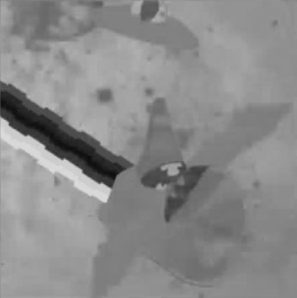

'4:2:0 Channel V'

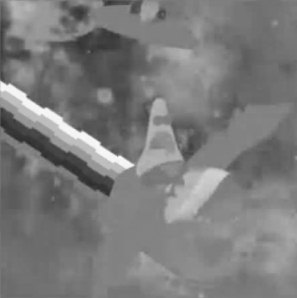

In [37]:
dw_420 = Image.fromarray(np.uint8(downsampling_420(green)), 'L')
display("4:2:0 Channel U", dw_420)

dw_420 = Image.fromarray(np.uint8(downsampling_420(blue)), 'L')
display("4:2:0 Channel V", dw_420)

### Interpolation by nearest neightbor

#### When uncompressing the images, we need to restore the real image size for those two channel. To do so, we use the nearest neightbor interpolation algorithm.
#### The PIL library does it nicely with resample = 1 being Image.NEAREST (nearest neightbor)

'Resized channel U'

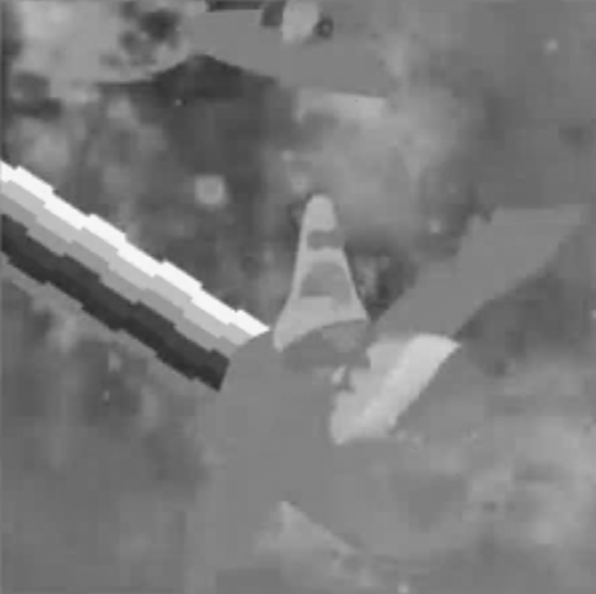

'Resized channel V'

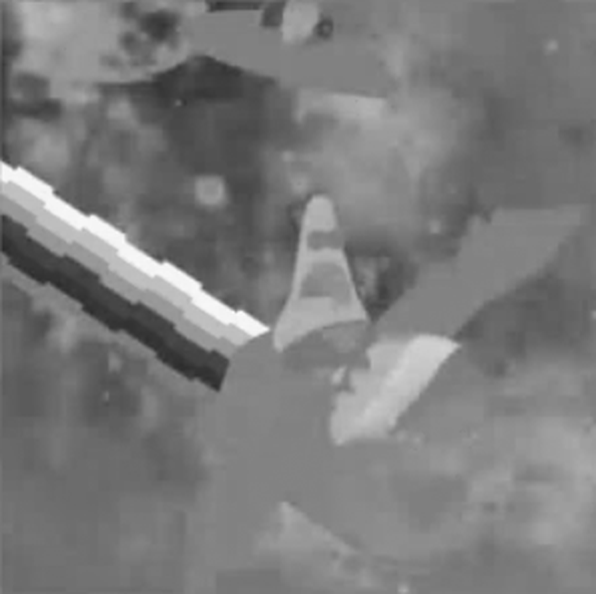

In [38]:
dw_422 = dw_422.resize((blue.shape[0], blue.shape[1]), resample=1)
display("Resized channel U", dw_422)

dw_420 = dw_420.resize((blue.shape[0], blue.shape[1]), resample=1)
display("Resized channel V", dw_420)

### Regroup the channels

##### When uncompressing, we need to restore the full RGB or YUV image into one. To do so, we merge the 3 channel images into one 3 dimensional matrix.

In [39]:
def regroup_channels(mat1, mat2, mat3):
    
    mat = np.zeros(shape=(mat1.shape[0], mat1.shape[1], 3))
    
    for i in range(mat1.shape[0]):
        for j in range(mat2.shape[1]):
            mat[i,j] = (mat1[i,j], mat2[i,j], mat3[i,j])
            
    return mat

# JPEG FULL FUNCTION

### Here is the JPEG algorithm function for grayscale image, followed  by the JPEG RGB/YUV compression/uncompression function

In [40]:
def bitstring_to_bytes(s):
    v = int(s, 2)
    b = bytearray()
    while v:
        b.append(v & 0xff)
        v >>= 8
    return bytes(b[::-1])

def jpeg_gray_algo(channel, is_rgb=True, q = 50):
    # Save dimensions
    original_dim = channel.shape
    
    # Make the channel multiple of 8 if not
    data = multiple_8(channel)
    
    # Split into macro-blocks
    macro_blocks = split(data)
    
    # DCT
    D8 = DCT(8)
    
    macros = np.array(macro_blocks)
    Im_DCT = np.round(D8 @ (macros - 128) @ D8.T)
    #Im_DCT = D8 @ (macros - 128) @ D8.T
    
    # Quantization
    if is_rgb :
        Im_q = np.round(Im_DCT / quantization(q))
    else:
        Im_q = np.round(Im_DCT / quantization_UV)
    
    # Zigzag
    Im_zig = []
    
    for i in range(len(Im_q)):
        Im_zig.append(zero_removal(zigzag(Im_q[i])))
        
    
    # Calculate the mean compression ratio, and do the Huffman
    # encoding at the same time
    means=0
    encoding = ''
    prev_dc = 0
    for macros_b in Im_zig:
        encoding += encode(macros_b, prev_dc)
        prev_dc = macros_b[0]

        if len(macros_b) != 0:
            means += 64 / len(macros_b)
        else:
            means += 64

    # Calculate Huffman compression ratio,
    huff_rat = len(encoding) / len(Im_zig)

    # Write into a file the Huffman compression result
    # Not useful since we do not have the metadata and the method
    # to combine the channels.
    """
    print("Huffman compression ratio:", huff_rat)
    with open('output.jpg', 'wb') as file:
        encoding = bitstring_to_bytes(encoding)
        file.write(encoding)
    """
    means /= len(Im_zig)
    #print("Mean compression ratio: ", means)
    
    # Reverse
    Im_rv_zig = []
    for i in range(len(Im_zig)):
        Im_rv_zig.append(reverse_zigzag(Im_zig[i]))

    # Reverse Quantification
    if is_rgb:
        reverse_quant = Im_rv_zig * quantization(q)
    else:
        reverse_quant = Im_rv_zig * quantization_UV

    # Reverse DCT
    reverse_dct = np.round(D8.T @ reverse_quant @ D8)
    reverse_dct += 128
    
    # Reverse Split
    recovered_im = reverse_split(reverse_dct ,data.shape[0], data.shape[1])
    
    # Reverse 8 multiple
    reco_Im = Image.fromarray(np.uint8(recovered_im), 'L')
    reco_Im = reco_Im.crop((0,0,original_dim[1], original_dim[0]))
    
    return np.uint8(recovered_im), means, huff_rat

In [41]:
def jpeg_compression(img, is_rgb=True, q=50, downsampling="4:4:4", show_channels=False):
    
    im = Image.open(img, 'r')
    im = im.convert("RGB")
    
    display("Image to compress",im)
    
    data = np.asarray(im)
    
    if not is_rgb:
        data = RGB2YUV(data)
        
    channel_1 = get_channel(data, 0)
    channel_2 = get_channel(data, 1)
    channel_3 = get_channel(data, 2)
    
    if downsampling == "4:2:2":
        channel_2 = downsampling_422(channel_2)
        channel_3 = downsampling_422(channel_3)
    elif downsampling == "4:2:0":
        channel_2 = downsampling_420(channel_2)
        channel_3 = downsampling_420(channel_3)
        
    # JPEG Compression
    compressed_1, means1, huff1 = jpeg_gray_algo(channel_1, q=q)
    print("Channel 1: done")
    compressed_2, means2, huff2 = jpeg_gray_algo(channel_2, is_rgb, q)
    print("Channel 2: done")
    compressed_3, means3, huff3 = jpeg_gray_algo(channel_3, is_rgb, q)
    print("Channel 3: done")
    
    comp_means = (means1 + means2 + means3) / 3
    huff_means = (huff1 + huff2 + huff3) / 3
    
    if show_channels:
        c1 = Image.fromarray(np.uint8(compressed_1), 'L')
        display("Channel 1",c1)
        c2 = Image.fromarray(np.uint8(compressed_2), 'L')
        display("Channel 2",c2)
        c3 = Image.fromarray(np.uint8(compressed_3), 'L')
        display("Channel 3",c3)
    
    # Use Nearest-Neighbor to rescale images
    if downsampling != "4:4:4":
        dw_2 = Image.fromarray(np.uint8(compressed_2), 'L')
        compressed_2 = np.asarray(dw_2.resize((compressed_1.shape[0], compressed_1.shape[1]), resample=1))
        
        dw_3 = Image.fromarray(np.uint8(compressed_3), 'L')
        compressed_3 = np.asarray(dw_3.resize((compressed_1.shape[0], compressed_1.shape[1]), resample=1))
        
    # Regroup 3 channels
    recovered_im = regroup_channels(compressed_1, compressed_2, compressed_3)

    
    # Print recovered image
    if not is_rgb:
        rc_im = Image.fromarray(np.uint8(recovered_im), 'RGB')
        display("YUV Compressed image",rc_im)
        recovered_im = YUV2RGB(recovered_im)
    rc_im = Image.fromarray(np.uint8(recovered_im), 'RGB')
    display("RGB Compressed image",rc_im)
    
    print("Macro-block coefs compression ratio = ", round(comp_means,3))
    print("Huffman compression ratio = ", round(huff_means,3))

### You can try it here with different images and q factor. 
#### is_rgb is True when using RGB compression and false when using YUV compression
#### show_channels displays the 3 grayscale (RGB or YUV) channels after compression

#### The compression ratio is the mean of each mean macro-block ratio compression for the 3 channels
#### The Huffman ratio is the mean between each huffman(not_compressed_file) / huffman(compressed_file) in order to see the ratio of bits we gain

'Image to compress'

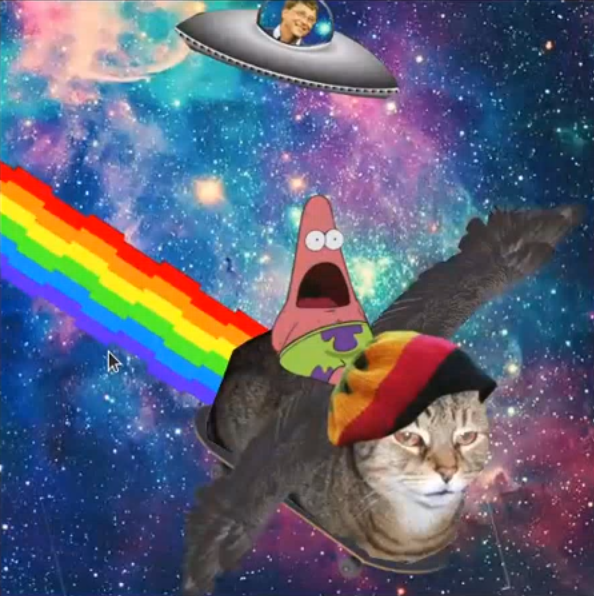

Channel 1: done
Channel 2: done
Channel 3: done


'RGB Compressed image'

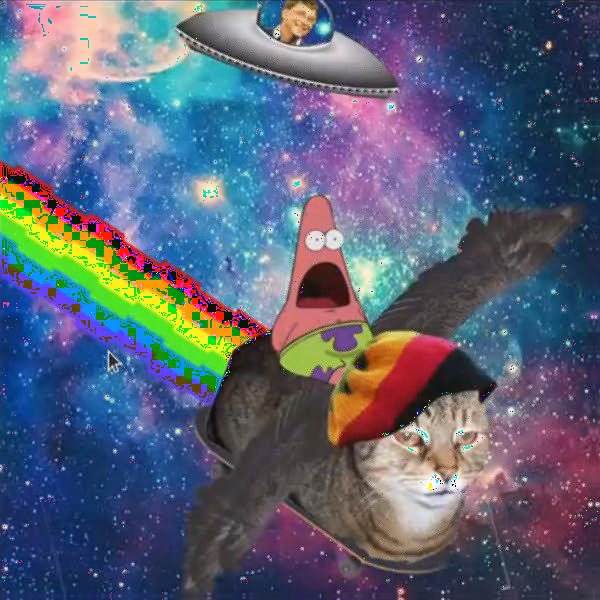

Macro-block coefs compression ratio =  7.136
Huffman compression ratio =  83.5


In [42]:
jpeg_compression("Images/rainbow_patrick.png", q=50, is_rgb=True, show_channels=False)

## Conclusion:
For now we don't really know why the compressed image looks so bad. Maybe we did something wrong with the DCT application and its inverse.

Nevertheless, this project made us understand quite depthly how a jpeg image is compressed and uncompressed.